# PoroTomo DAS Data Processing Tutorial for hdf5 Files via h5py
Prior to running this script, make sure the following are installed within your Python environment:
 - boto3
 - numpy
 - matplotlib
 - h5py
 - s3fs
 - sys
 - os
    
After installation, run the following:

In [37]:
import boto3, os, logging, botocore
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

import sys
import os

import s3fs
import h5py

boto3.set_stream_logger('boto3', logging.INFO)
s3 = boto3.resource('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED)) 
bucket = s3.Bucket('nrel-pds-porotomo')
cwd = os.getcwd()

## Showing Info for PoroTomo AWS S3 Bucket

In [2]:
s3.meta.client.head_bucket(Bucket='nrel-pds-porotomo')

{'ResponseMetadata': {'RequestId': '2AYNSZRNYB1DHHJQ',
  'HostId': 'h3R49p6/2if3g9kytvKB2hiL42qIUCQYcQIJhpcOsasEogEeBlY3CnbpWnBpVHZ3wKzfdWj4qdI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'h3R49p6/2if3g9kytvKB2hiL42qIUCQYcQIJhpcOsasEogEeBlY3CnbpWnBpVHZ3wKzfdWj4qdI=',
   'x-amz-request-id': '2AYNSZRNYB1DHHJQ',
   'date': 'Mon, 04 Dec 2023 18:41:14 GMT',
   'x-amz-bucket-region': 'us-west-2',
   'x-amz-access-point-alias': 'false',
   'content-type': 'application/xml',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

## Total Number of Objects in PoroTomo S3 Bucket
This code block shows the total number of objects within the bucket. For the purposes of this tutorial, we will use only two data files from 3/15, including and following a 'mystery event.'

In [10]:
count = 0
for object in bucket.objects.all():
    count+=1
    
count

4909186

## Accessing the Data using h5py
This can be done by pulling the data directly into the notebook from S3.

The files used in this tutorial are specified here:

In [3]:
keys = ['DAS/H5/DASH/20160315/PoroTomo_iDAS16043_160315083149.h5',
        'DAS/H5/DASH/20160315/PoroTomo_iDAS16043_160315083219.h5']


In [6]:
data_stream = []
s3 = s3fs.S3FileSystem(anon=True)
print('hdf5 file structures:')
for key in keys:
    path = 's3://nrel-pds-porotomo/'+key
    with s3.open(path, 'rb') as fp:
        with h5py.File(fp, 'r') as f:
            das = np.array(f['das'])
            data_stream.append(das)
            print(list(f))


hdf5 file structures:
['channel', 'crs', 'das', 't', 'trace', 'x', 'y', 'z']
['channel', 'crs', 'das', 't', 'trace', 'x', 'y', 'z']


## Plotting Raw Data
### Plotting Individual Traces
Individual traces within a stream can be accessed by accessing individual columns of the numpy arrays. In this code block, a subset of the traces are placed into an array and plotted to show change in amplitude over time at different positions along the cable.

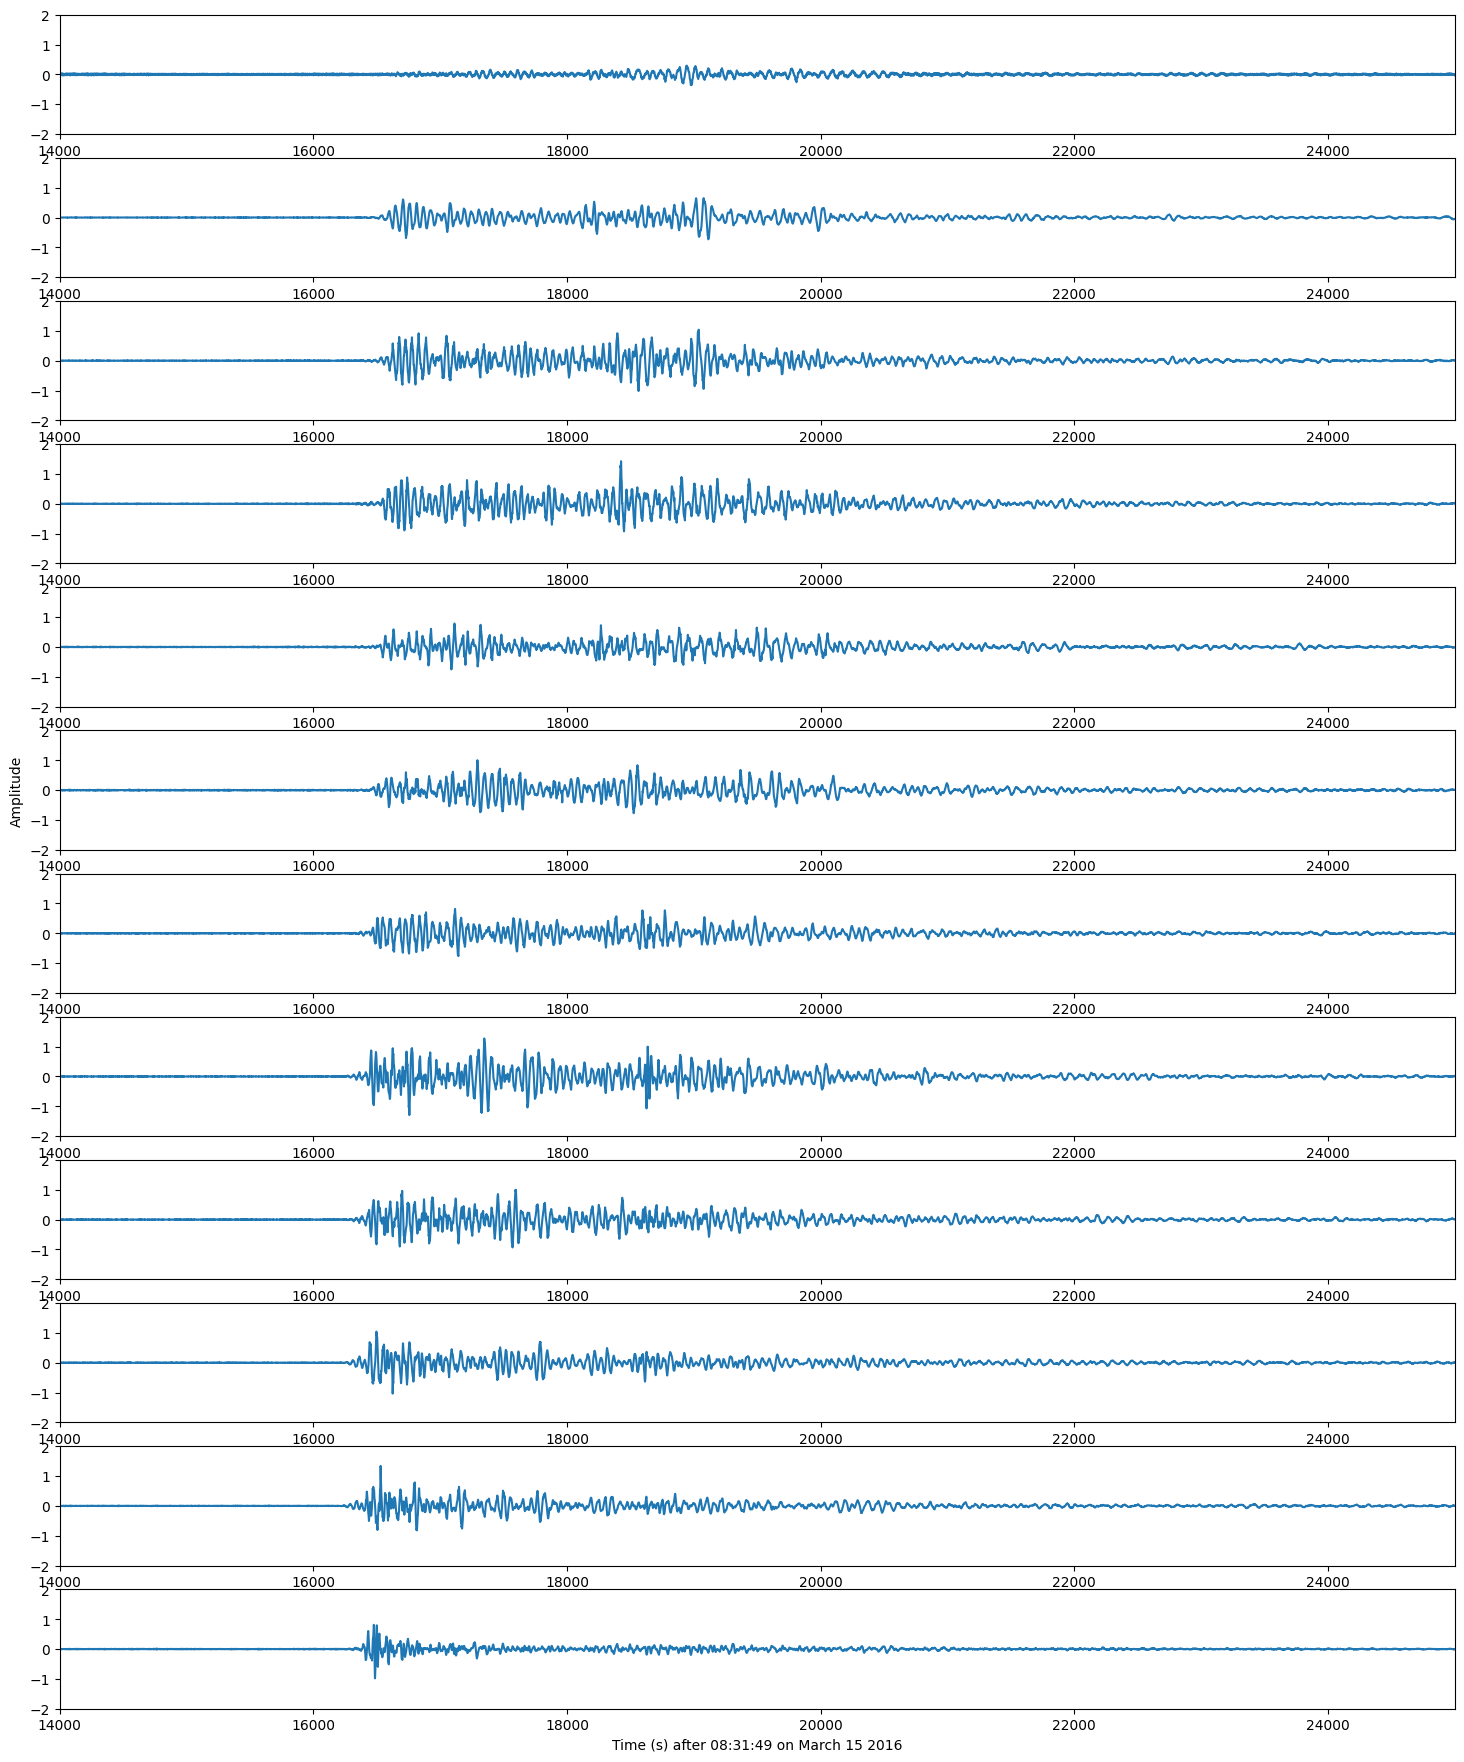

In [11]:
traces = []; trace_no=0
start_trace=40; trace_inc = 15; num_traces = 12
ylim = [-2,2]; xlim=[14000,25000]
data = data_stream[0]

for index in np.arange(num_traces):
    traces.append(data[:,start_trace+trace_inc*index])
    
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(12,figsize=(18,22))
ax1.plot(np.array(traces[trace_no].data)); ax1.set_ylim(ylim); ax1.set_xlim(xlim); trace_no+=1
ax2.plot(np.array(traces[trace_no].data)); ax2.set_ylim(ylim); ax2.set_xlim(xlim); trace_no+=1
ax3.plot(np.array(traces[trace_no].data)); ax3.set_ylim(ylim); ax3.set_xlim(xlim); trace_no+=1
ax4.plot(np.array(traces[trace_no].data)); ax4.set_ylim(ylim); ax4.set_xlim(xlim); trace_no+=1
ax5.plot(np.array(traces[trace_no].data)); ax5.set_ylim(ylim); ax5.set_xlim(xlim); trace_no+=1
ax6.plot(np.array(traces[trace_no].data)); ax6.set_ylim(ylim); ax6.set_xlim(xlim); trace_no+=1
ax6.set_ylabel('Amplitude')
ax7.plot(np.array(traces[trace_no].data)); ax7.set_ylim(ylim); ax7.set_xlim(xlim); trace_no+=1
ax8.plot(np.array(traces[trace_no].data)); ax8.set_ylim(ylim); ax8.set_xlim(xlim); trace_no+=1
ax9.plot(np.array(traces[trace_no].data)); ax9.set_ylim(ylim); ax9.set_xlim(xlim); trace_no+=1
ax10.plot(np.array(traces[trace_no].data)); ax10.set_ylim(ylim); ax10.set_xlim(xlim); trace_no+=1
ax11.plot(np.array(traces[trace_no].data)); ax11.set_ylim(ylim); ax11.set_xlim(xlim); trace_no+=1
ax12.plot(np.array(traces[trace_no].data)); ax12.set_ylim(ylim); ax12.set_xlim(xlim); trace_no+=1
ax12.set_xlabel('Time (s) after 08:31:49 on March 15 2016')
plt.show()
    

### Size of Data

In [12]:
raw_data = data_stream
size = sys.getsizeof(raw_data[0])+sys.getsizeof(raw_data[1])
print("size of two raw datasets: {:.4f} GB".format(size*10**-9))

raw_data = []
raw_data.append(data_stream[0].T)
raw_data.append(data_stream[1].T)


size of two raw datasets: 2.0930 GB


### Determining Upper and Lower Limits of the Data
In order to determine upper and lower bounds for the colorbar, the 99th percentile, maximum value, and standard deviation are calculated. 

In [13]:
vm0 = np.percentile(raw_data[0], 99)
std0 = np.std(raw_data[0])
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is  {:.4f}".format(vm0, raw_data[0].max(),std0))


The 99th percentile is 0.0397; the max amplitude is 2.4027; the standard deviation is  0.0292


In [14]:
vm1 = np.percentile(raw_data[1], 99)
std1 = np.std(raw_data[1])
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is  {:.4f}".format(vm1, raw_data[1].max(),std1))


The 99th percentile is 0.0134; the max amplitude is 2.0574; the standard deviation is  0.0193


### Plotting all Traces as an Image Using imshow

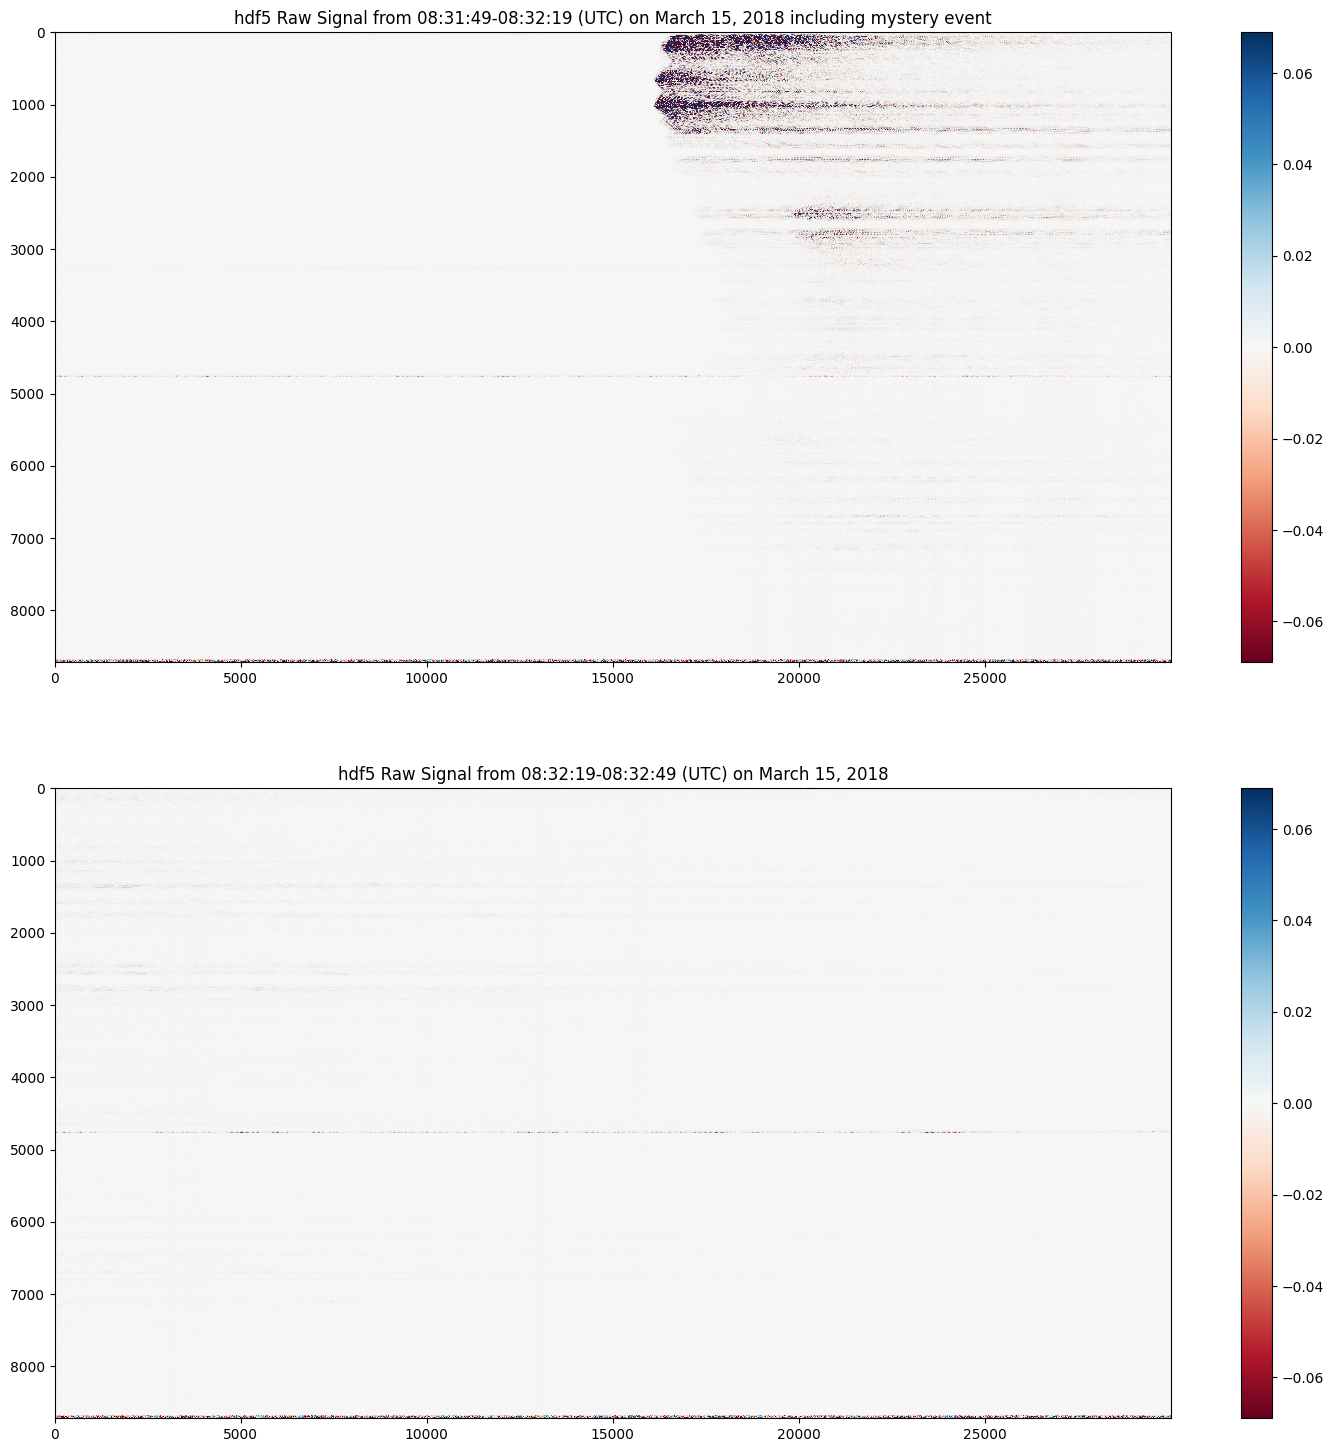

In [15]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(18,18))
mystery_event = ax1.imshow(raw_data[0], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.colorbar(mystery_event,ax=ax1)
ax1.set_title('hdf5 Raw Signal from 08:31:49-08:32:19 (UTC) on March 15, 2018 including mystery event')

noise = ax2.imshow(raw_data[1], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.colorbar(noise,ax=ax2)
ax2.set_title('hdf5 Raw Signal from 08:32:19-08:32:49 (UTC) on March 15, 2018')

plt.show()

### Isolating the Mystery Event

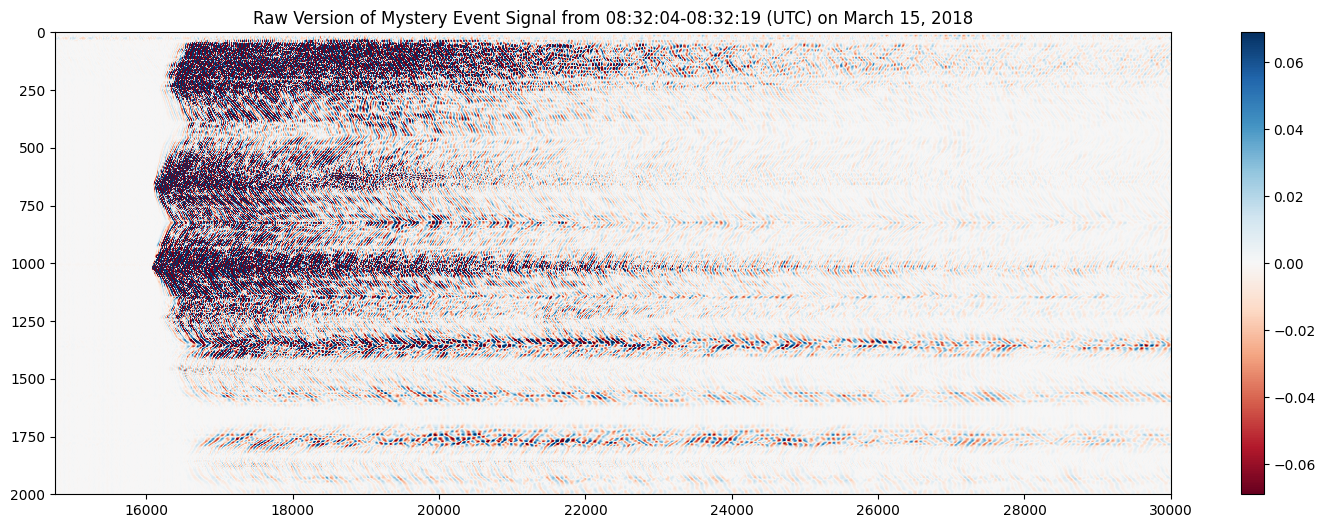

In [16]:
plt.figure(figsize=(18,6))
mystery_event = plt.imshow(raw_data[0], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.xlim(14750,30000)
plt.ylim(2000,0)

plt.colorbar(mystery_event)
plt.title('Raw Version of Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
plt.show()

## Filtering
Scipy.signal's butter function offers the following filter types:
 - bandpass
 - bandstop
 - lowpass
 - highpass
 
Here we will apply the low pass butterworth filter to only the mystery event data stream.
 
### Applying Low Pass Filter

In [17]:
lowpass_filter = signal.butter(2,Wn=0.001,btype='low',output='sos')
filt_data = signal.sosfilt(lowpass_filter, raw_data[0])

### Plotting Filtered Data

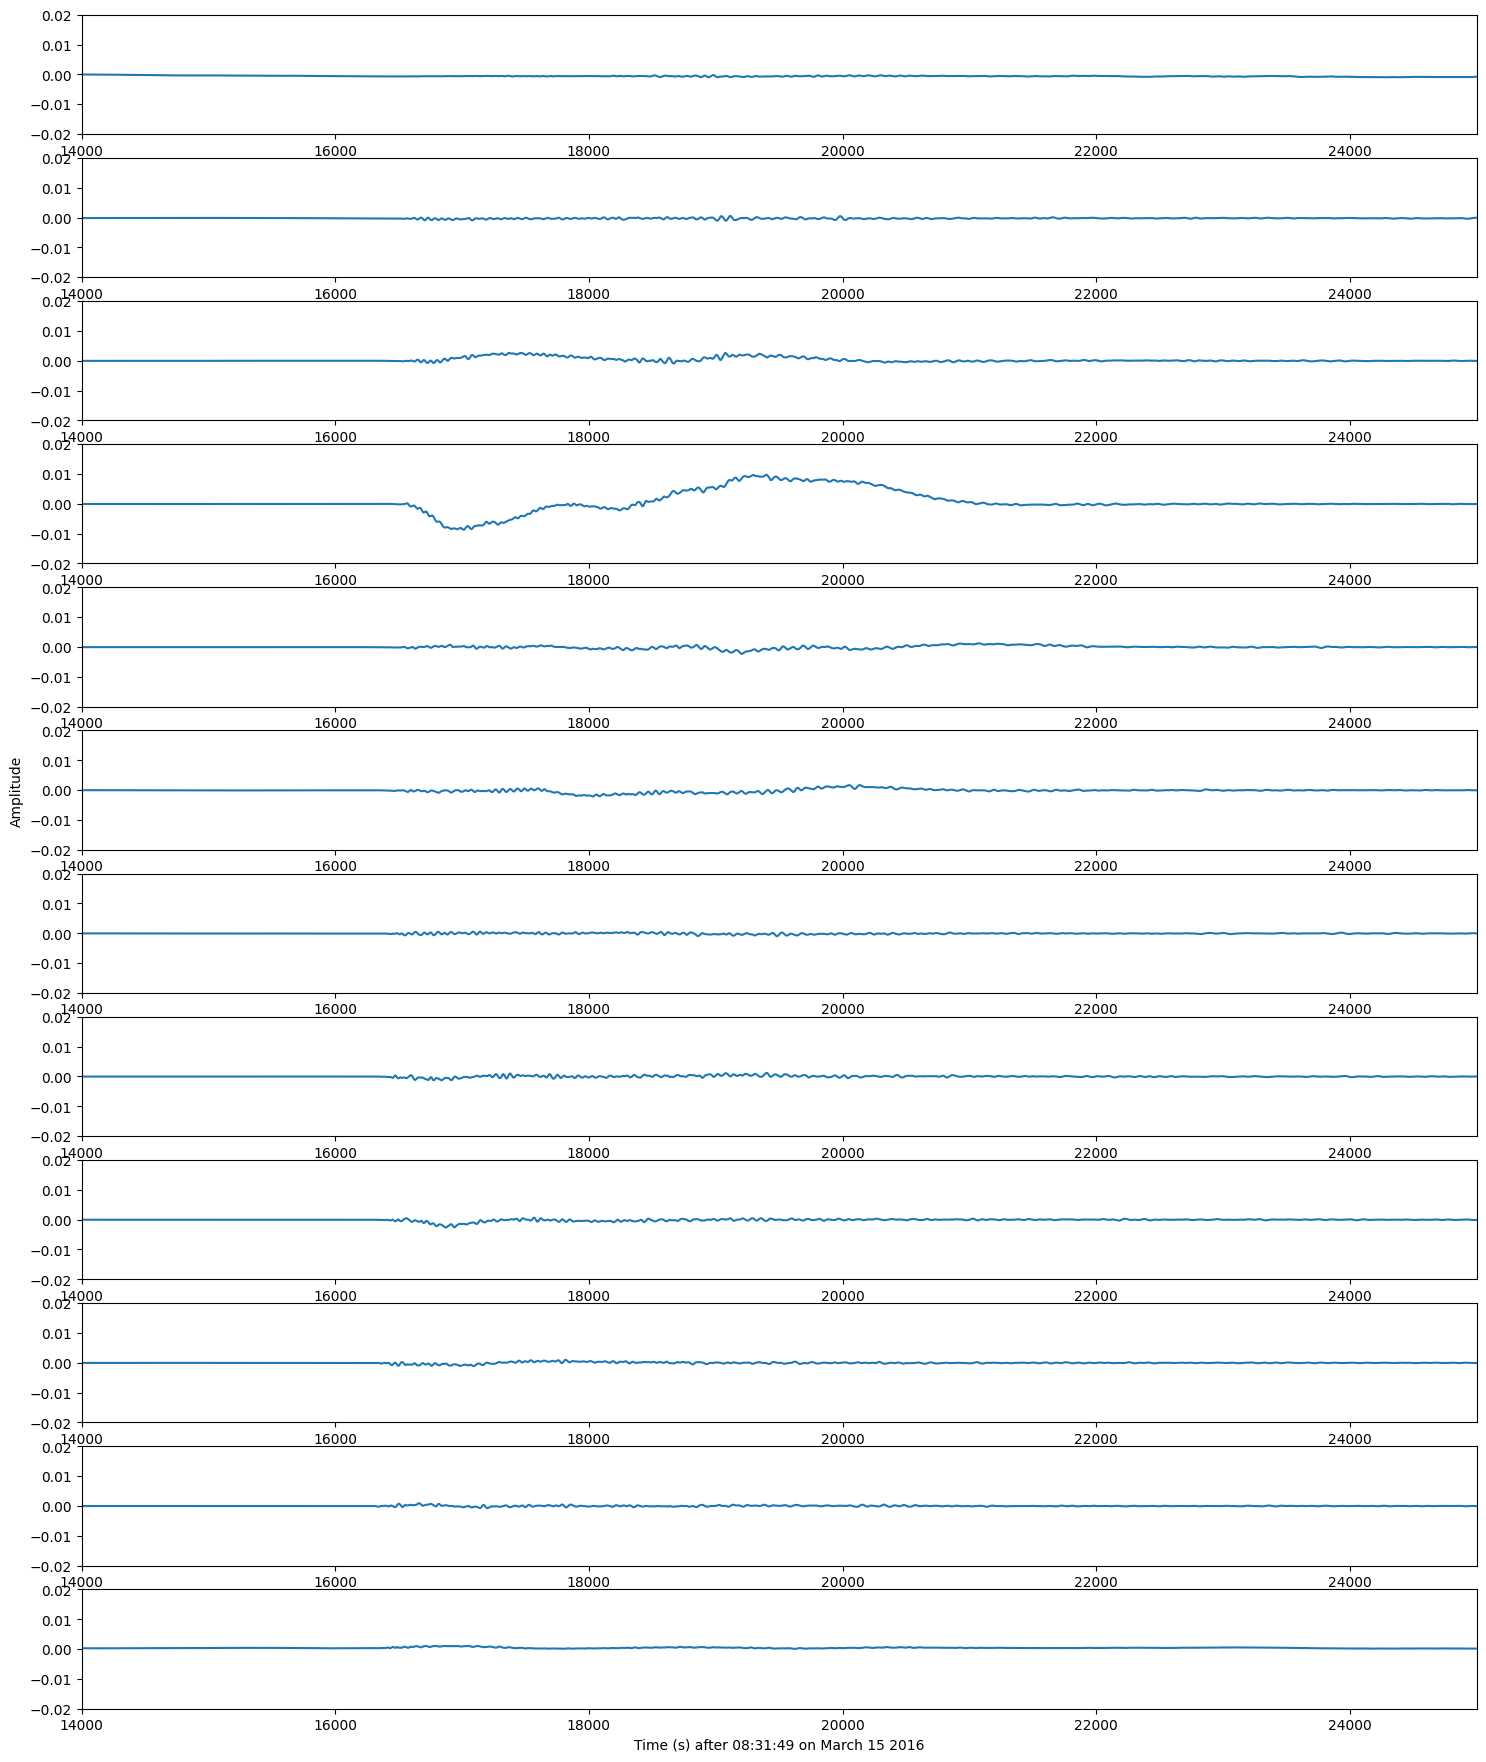

In [19]:
traces = []; trace_no=0
start_trace=40; trace_inc = 15; num_traces = 12
ylim = [-.02,.02]; xlim=[14000,25000]
data = filt_data.T

for index in np.arange(num_traces):
    traces.append(data[:,start_trace+trace_inc*index])

fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(12,figsize=(18,22))
ax1.plot(np.array(traces[trace_no].data)); ax1.set_ylim(ylim); ax1.set_xlim(xlim); trace_no+=1
ax2.plot(np.array(traces[trace_no].data)); ax2.set_ylim(ylim); ax2.set_xlim(xlim); trace_no+=1
ax3.plot(np.array(traces[trace_no].data)); ax3.set_ylim(ylim); ax3.set_xlim(xlim); trace_no+=1
ax4.plot(np.array(traces[trace_no].data)); ax4.set_ylim(ylim); ax4.set_xlim(xlim); trace_no+=1
ax5.plot(np.array(traces[trace_no].data)); ax5.set_ylim(ylim); ax5.set_xlim(xlim); trace_no+=1
ax6.plot(np.array(traces[trace_no].data)); ax6.set_ylim(ylim); ax6.set_xlim(xlim); trace_no+=1
ax6.set_ylabel('Amplitude')
ax7.plot(np.array(traces[trace_no].data)); ax7.set_ylim(ylim); ax7.set_xlim(xlim); trace_no+=1
ax8.plot(np.array(traces[trace_no].data)); ax8.set_ylim(ylim); ax8.set_xlim(xlim); trace_no+=1
ax9.plot(np.array(traces[trace_no].data)); ax9.set_ylim(ylim); ax9.set_xlim(xlim); trace_no+=1
ax10.plot(np.array(traces[trace_no].data)); ax10.set_ylim(ylim); ax10.set_xlim(xlim); trace_no+=1
ax11.plot(np.array(traces[trace_no].data)); ax11.set_ylim(ylim); ax11.set_xlim(xlim); trace_no+=1
ax12.plot(np.array(traces[trace_no].data)); ax12.set_ylim(ylim); ax12.set_xlim(xlim); trace_no+=1
ax12.set_xlabel('Time (s) after 08:31:49 on March 15 2016')
plt.show()

In [20]:
vm_filt = np.percentile(filt_data, 99)
std_filt = np.std(filt_data)
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is  {:.4f}".format(vm_filt, filt_data.max(),std_filt))


The 99th percentile is 0.0001; the max amplitude is 0.0864; the standard deviation is  0.0010


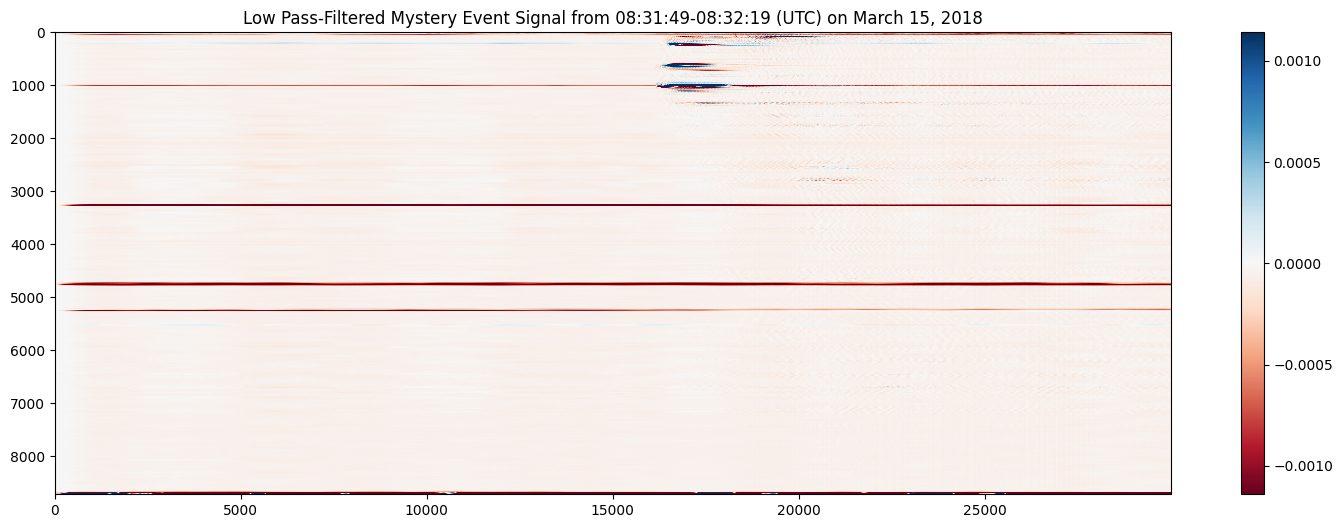

In [21]:
plt.figure(figsize=(18,6))
mystery_event = plt.imshow(filt_data, cmap="RdBu", vmin=-vm_filt-std_filt, vmax=vm_filt+std_filt, aspect='auto')
plt.colorbar()
plt.title('Low Pass-Filtered Mystery Event Signal from 08:31:49-08:32:19 (UTC) on March 15, 2018')
plt.show()


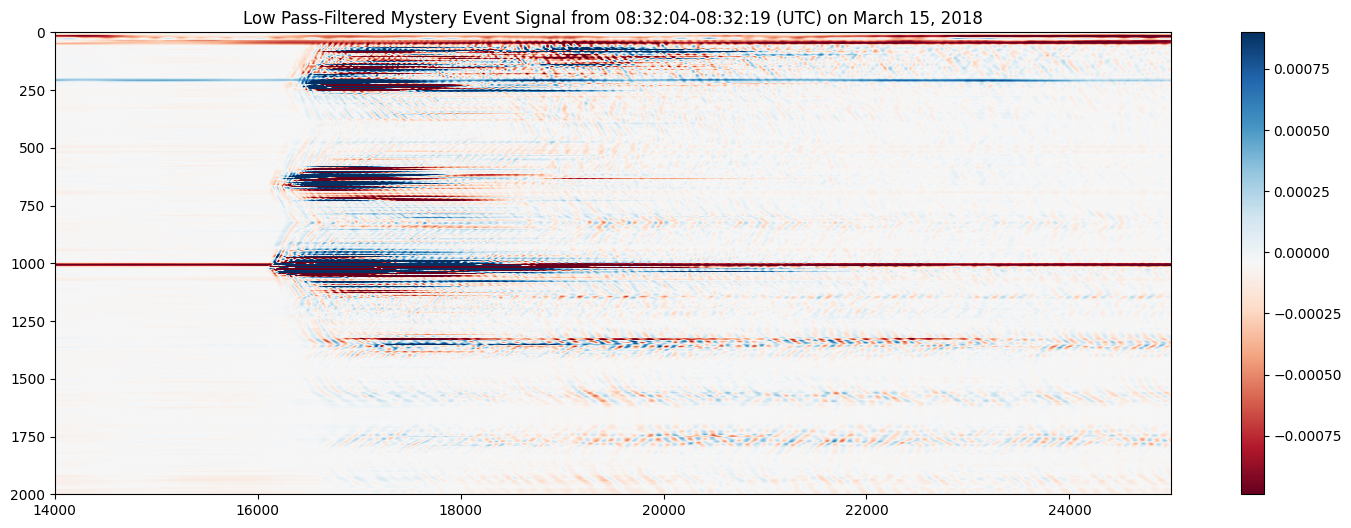

In [22]:
plt.figure(figsize=(18,6))
myster_event = plt.imshow(filt_data, cmap="RdBu", vmin=-vm_filt+std_filt, vmax=vm_filt-std_filt, aspect='auto')
plt.xlim(14000,25000)
plt.ylim(2000,0)

plt.colorbar()
plt.title('Low Pass-Filtered Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
plt.show()


## Resampling the Data
Scipy.signal's resample function offers downsampling by specifying the desired number of samples in the resampled signal. Here, we want to downsample by a factor of 100, so our target number of samples is 300.

In [23]:
sampling_rate_stream = 1000
sampling_rate = sampling_rate_stream/100 # in Hz or samples per s
num_samples=int(30000/100)
resamp_data = filt_data.copy().T
resamp_data=signal.resample(resamp_data,num_samples)

/var/folders/hf/_kpcp9_s4jd0xjzgk24gg34h1s__sk/T/ipykernel_20770/1783902321.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(np.arange(14000,25000,2000))
/var/folders/hf/_kpcp9_s4jd0xjzgk24gg34h1s__sk/T/ipykernel_20770/1783902321.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(np.arange(14000,25000,2000))
/var/folders/hf/_kpcp9_s4jd0xjzgk24gg34h1s__sk/T/ipykernel_20770/1783902321.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(np.arange(14000,25000,2000))
/var/folders/hf/_kpcp9_s4jd0xjzgk24gg34h1s__sk/T/ipykernel_20770/1783902321.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a

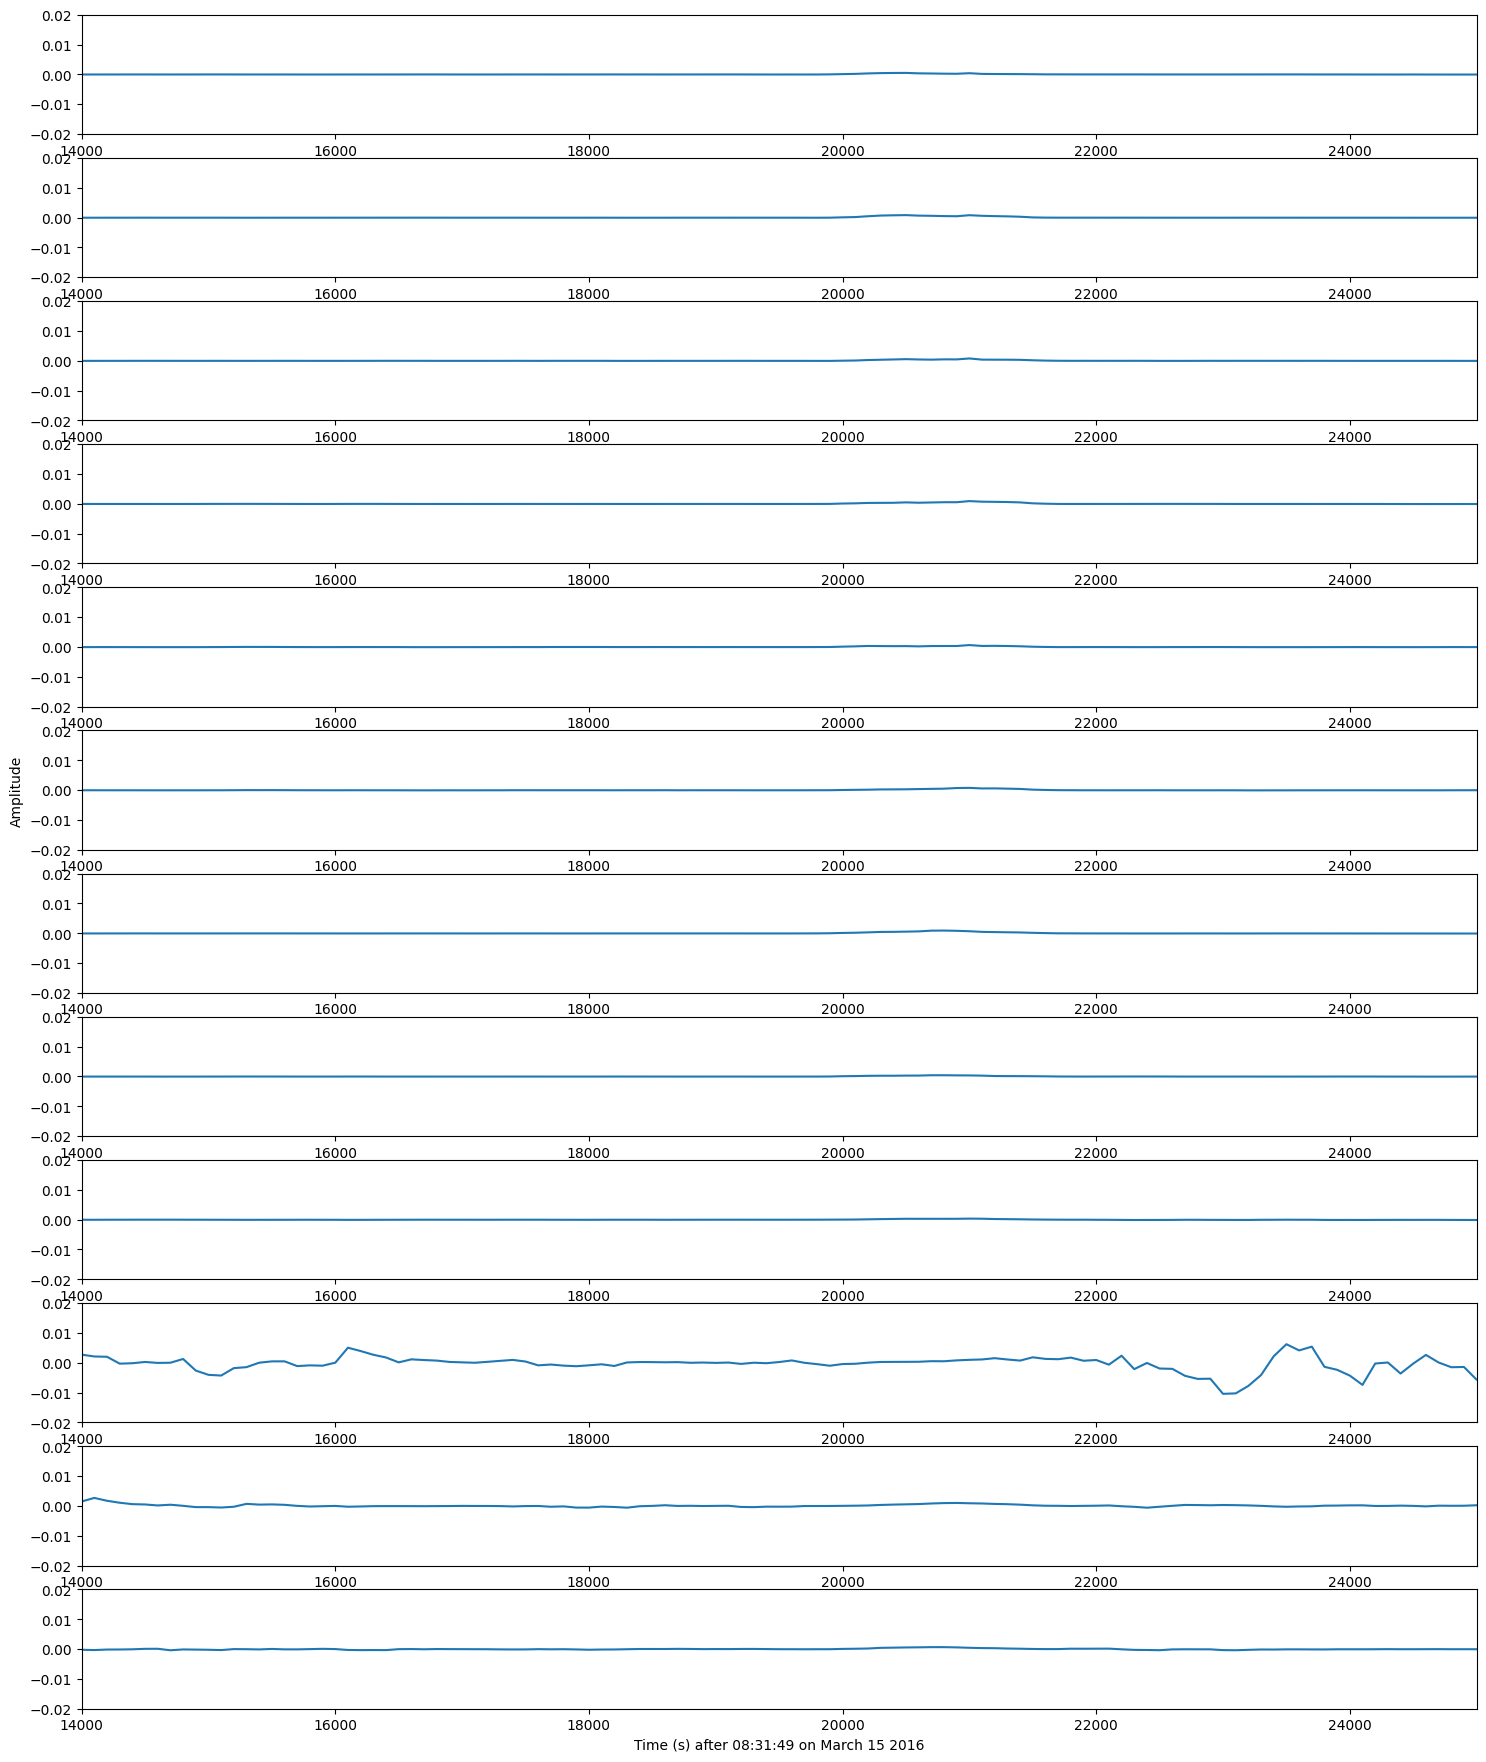

In [36]:
traces = []; trace_no=0
start_trace=40; trace_inc = 15; num_traces = 12
ylim = [-.02,.02]; xlim=[14000,25000]
data = resamp_data

for index in np.arange(num_traces):
    traces.append(data[:,start_trace+trace_inc*index])

ylim = [-.02,.02]; xlim=[14000/(sampling_rate_stream/sampling_rate),25000/(sampling_rate_stream/sampling_rate)]

fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(12,figsize=(18,22))
ax1.plot(np.array(traces[trace_no].data)); ax1.set_ylim(ylim); ax1.set_xlim(xlim); trace_no+=1
ax1.set_xticklabels(np.arange(14000,25000,2000))
ax2.plot(np.array(traces[trace_no].data)); ax2.set_ylim(ylim); ax2.set_xlim(xlim); trace_no+=1
ax2.set_xticklabels(np.arange(14000,25000,2000))
ax3.plot(np.array(traces[trace_no].data)); ax3.set_ylim(ylim); ax3.set_xlim(xlim); trace_no+=1
ax3.set_xticklabels(np.arange(14000,25000,2000))
ax4.plot(np.array(traces[trace_no].data)); ax4.set_ylim(ylim); ax4.set_xlim(xlim); trace_no+=1
ax4.set_xticklabels(np.arange(14000,25000,2000))
ax5.plot(np.array(traces[trace_no].data)); ax5.set_ylim(ylim); ax5.set_xlim(xlim); trace_no+=1
ax5.set_xticklabels(np.arange(14000,25000,2000))
ax6.plot(np.array(traces[trace_no].data)); ax6.set_ylim(ylim); ax6.set_xlim(xlim); trace_no+=1
ax6.set_xticklabels(np.arange(14000,25000,2000))
ax6.set_ylabel('Amplitude')
ax7.plot(np.array(traces[trace_no].data)); ax7.set_ylim(ylim); ax7.set_xlim(xlim); trace_no+=1
ax7.set_xticklabels(np.arange(14000,25000,2000))
ax8.plot(np.array(traces[trace_no].data)); ax8.set_ylim(ylim); ax8.set_xlim(xlim); trace_no+=1
ax8.set_xticklabels(np.arange(14000,25000,2000))
ax9.plot(np.array(traces[trace_no].data)); ax9.set_ylim(ylim); ax9.set_xlim(xlim); trace_no+=1
ax9.set_xticklabels(np.arange(14000,25000,2000))
ax10.plot(np.array(traces[trace_no].data)); ax10.set_ylim(ylim); ax10.set_xlim(xlim); trace_no+=1
ax10.set_xticklabels(np.arange(14000,25000,2000))
ax11.plot(np.array(traces[trace_no].data)); ax11.set_ylim(ylim); ax11.set_xlim(xlim); trace_no+=1
ax11.set_xticklabels(np.arange(14000,25000,2000))
ax12.plot(np.array(traces[trace_no].data)); ax12.set_ylim(ylim); ax12.set_xlim(xlim); trace_no+=1
ax12.set_xticklabels(np.arange(14000,25000,2000))
ax12.set_xlabel('Time (s) after 08:31:49 on March 15 2016')
plt.show()

In [28]:
size = sys.getsizeof(resamp_data)
print("{:.4f} GB".format(size * 10**-9))

0.0209 GB


In [29]:
resamp_data = resamp_data.T

In [30]:
vm_resamp = np.percentile(resamp_data, 99)
std_resamp = np.std(resamp_data)
print("The 99th percentile is {:.4f}; the max amplitude is {:.4f}; the standard deviation is {:.4f}".format(vm_resamp, resamp_data.max(),std_resamp))


The 99th percentile is 0.0001; the max amplitude is 0.0859; the standard deviation is 0.0010


/var/folders/hf/_kpcp9_s4jd0xjzgk24gg34h1s__sk/T/ipykernel_20770/1968751885.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(-5000,30000,5000))


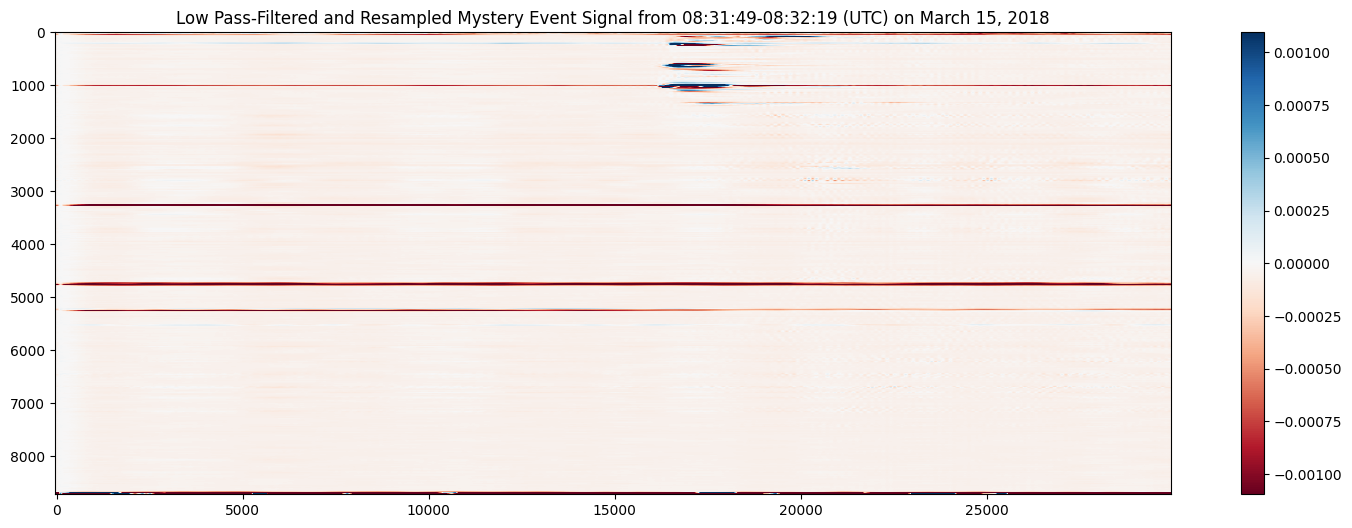

In [31]:
fig, ax = plt.subplots(figsize=(18,6))
mystery_event = plt.imshow(resamp_data, cmap="RdBu", vmin=-vm_resamp-std_resamp, vmax=vm_resamp+std_resamp, aspect='auto')
ax.set_xticklabels(np.arange(-5000,30000,5000))
plt.colorbar()
plt.title('Low Pass-Filtered and Resampled Mystery Event Signal from 08:31:49-08:32:19 (UTC) on March 15, 2018')
plt.show()


/var/folders/hf/_kpcp9_s4jd0xjzgk24gg34h1s__sk/T/ipykernel_20770/3774834154.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(14000,30000,2000))


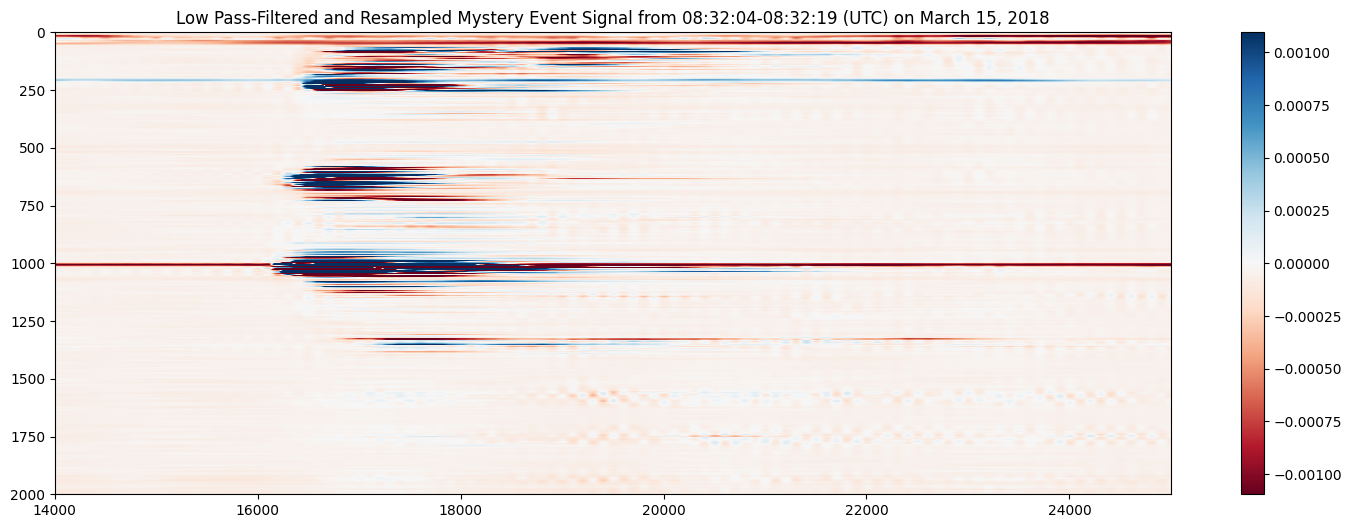

In [32]:
fig, ax = plt.subplots(figsize=(18,6))
mystery_event = plt.imshow(resamp_data, cmap="RdBu", vmin=-vm_resamp-std_resamp, vmax=vm_resamp+std_resamp, aspect='auto')
plt.xlim(14000/(sampling_rate_stream/sampling_rate),25000/(sampling_rate_stream/sampling_rate))
plt.ylim(2000,0)
ax.set_xticklabels(np.arange(14000,30000,2000))
plt.colorbar(mystery_event)
plt.title('Low Pass-Filtered and Resampled Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
plt.show()

## Comparison of the three Mystery Event Images

/var/folders/hf/_kpcp9_s4jd0xjzgk24gg34h1s__sk/T/ipykernel_20770/914149496.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(np.arange(14000,30000,2000))


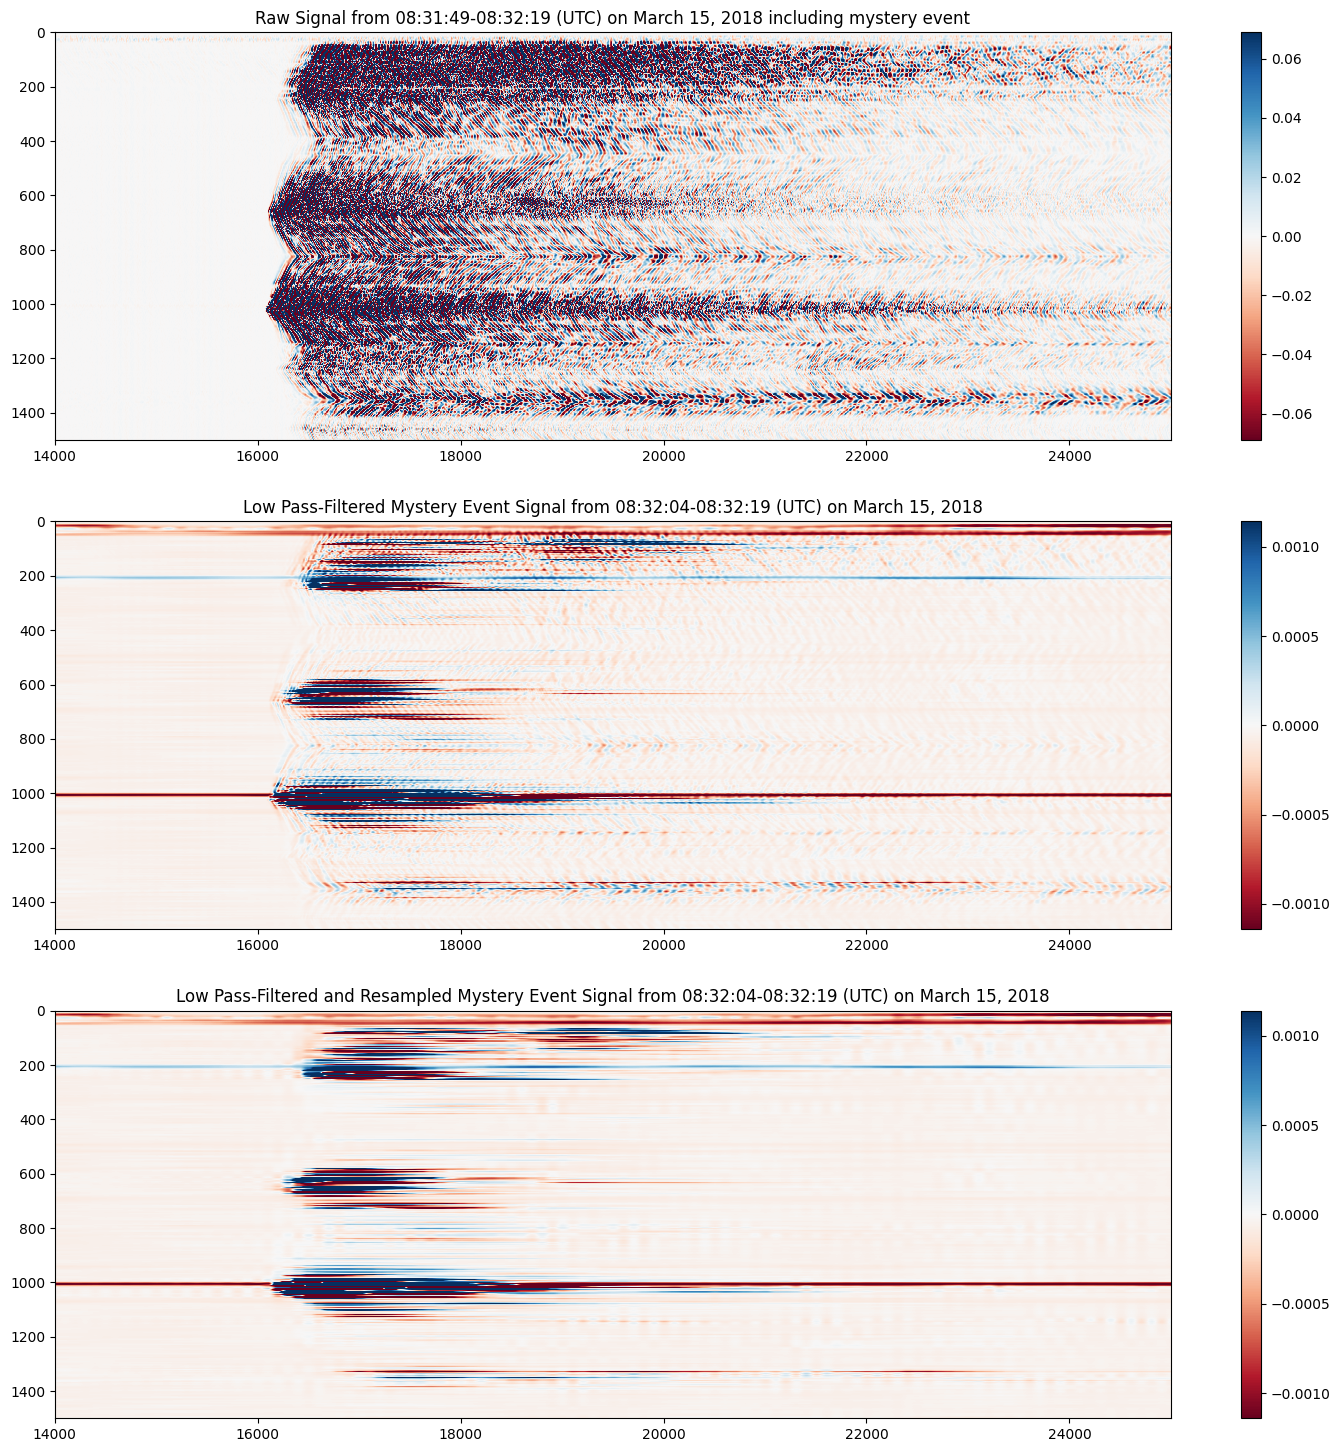

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(18,18))
mystery_event = ax1.imshow(raw_data[0], cmap="RdBu", vmin=-vm0-std0, vmax=vm0+std0, aspect='auto')
plt.colorbar(mystery_event,ax=ax1)
ax1.set_title('Raw Signal from 08:31:49-08:32:19 (UTC) on March 15, 2018 including mystery event')
ax1.set_xlim(14000,25000)
ax1.set_ylim(1500,0)

filt = ax2.imshow(filt_data, cmap="RdBu", vmin=-vm_filt-std_filt, vmax=vm_filt+std_filt, aspect='auto')
plt.colorbar(filt,ax=ax2)
ax2.set_title('Low Pass-Filtered Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
ax2.set_xlim(14000,25000)
ax2.set_ylim(1500,0)

resamp = ax3.imshow(resamp_data, cmap="RdBu", vmin=-vm_filt-std_filt, vmax=vm_filt+std_filt, aspect='auto')
plt.colorbar(resamp,ax=ax3)
ax3.set_title('Low Pass-Filtered and Resampled Mystery Event Signal from 08:32:04-08:32:19 (UTC) on March 15, 2018')
ax3.set_xlim(14000/(sampling_rate_stream/sampling_rate),25000/(sampling_rate_stream/sampling_rate))
ax3.set_ylim(1500,0)
ax3.set_xticklabels(np.arange(14000,30000,2000))
plt.show()